In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("main_df.csv", low_memory=False)

In [3]:
df.head(1)

,acn,trans_id,timestamp,item,item_group,total,membership,group,city,state,zipcode,lat,long,category
0,11,37777,2015-08-12 16:03:00,Core Power,Beverage,2.8,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar


In [4]:
df.acn.nunique()

2725

In [103]:
itemized = pd.pivot_table(df, values="total",index="acn",columns="item_group",aggfunc="sum",fill_value=0)

In [104]:
itemized.columns

Index(['24 Hour of Tennis', 'Accessories', 'Adult Clinics', 'Apparel', 'Beer',
       'Beverage', 'Camp', 'Court Time', 'Date Night', 'Dinners',
       'Facility Rental', 'Fitness Lessons', 'Fitness Special Event',
       'Food & Consumables', 'Food Allowance', 'Guest Fee',
       'Homeowner Membership Initiation', 'Junior Clinics', 'Kid Fit',
       'Leagues', 'Membership Dues', 'Membership Initiation',
       'Personal Training', 'Racquet Rental', 'Racquets',
       'Restring/ Labor Only', 'Shoes', 'Social Event', 'Special Event',
       'Sponsorship', 'String', 'Swim Camp', 'Swim Lessons',
       'Teen Performance Camp', 'Tennis Balls', 'Tennis Lessons', 'Wine'],
      dtype='object', name='item_group')

---

## Are there perceivable segments based on location and median spend?

In [46]:
loc_spend = df[(df.lat.notna()) & (df.lat.notna())]
loc_spend = df[["acn","lat","long","total"]]
loc_spend = loc_spend.groupby(["acn","lat","long"])[["total"]].sum().reset_index().set_index("acn").drop(2512,axis=0)

In [47]:
loc_spend.head()

,lat,long,total
acn,,,
1303,29.714595,-98.285693,1675.85
1317,29.719981,-98.200992,232.38
1320,29.713125,-98.203599,1858.99
1321,29.719981,-98.200992,10.00
1322,29.739218,-98.207010,60.00


In [56]:
loc_spend = loc_spend[loc_spend.long <= -98]

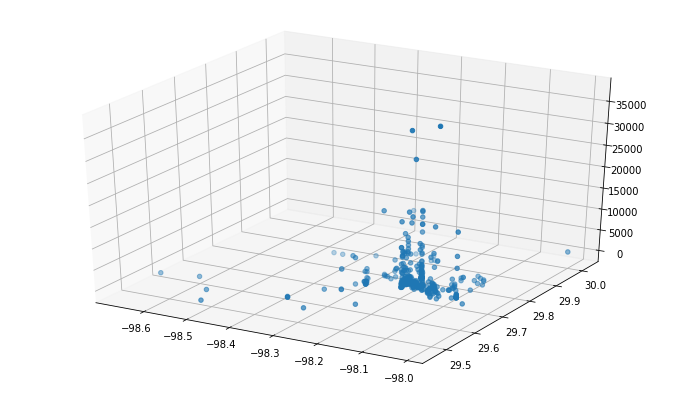

In [57]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, projection='3d')

# Plot models:
ax.scatter(loc_spend.long,loc_spend.lat,loc_spend.total)

## KMeans Clustering

In [95]:
from sklearn.cluster import KMeans

In [119]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(itemized)

In [120]:
clusters = pd.DataFrame(index=itemized.index, data=kmeans.labels_,columns=["cluster"])

In [121]:
with_clusters = itemized.join(clusters)

In [122]:
with_clusters.cluster.value_counts()

0    2357
1     230
4     127
2      10
3       1
Name: cluster, dtype: int64

In [126]:
with_clusters["Grand Total"] = with_clusters.sum(axis=1)

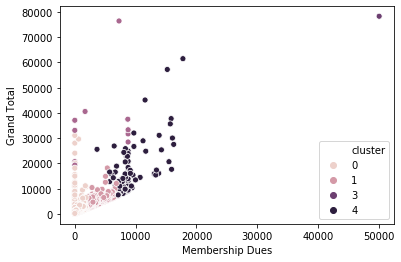

In [129]:
sns.scatterplot(x="Membership Dues",y="Grand Total",data=with_clusters, hue="cluster")

In [174]:
categorical = pd.pivot_table(df, values="total",index="acn",columns="category",aggfunc="sum",fill_value=0)
categorical["Grand Total"] = categorical.sum(axis=1)

In [175]:
categorical = categorical.join(clusters)

In [176]:
categorical.head()

,Admin,Bar,Event,Fitness,Pro Shop,Program,Tennis,Grand Total,cluster
acn,,,,,,,,,
11,0.00,801.58,80.00,0.0,95.12,90.0,208.30,1275.00,0
17,0.00,9.50,0.00,0.0,10.00,0.0,30.00,49.50,0
23,0.00,1015.45,0.00,0.0,10.83,0.0,1614.26,2640.54,0
33,3341.25,247.31,105.12,0.0,52.94,0.0,36.00,3782.62,1
34,5231.80,14.28,2552.20,0.0,0.00,0.0,0.00,7798.28,1


In [177]:
categorical.cluster.value_counts()

0    2357
1     230
4     127
2      10
3       1
Name: cluster, dtype: int64

In [178]:
condition = [categorical.cluster == 0, categorical.cluster == 1, categorical.cluster == 2, categorical.cluster == 3, categorical.cluster == 4]
choice = ["one","two","three","four","five"]
categorical["cluster_label"] = np.select(condition,choice,0)

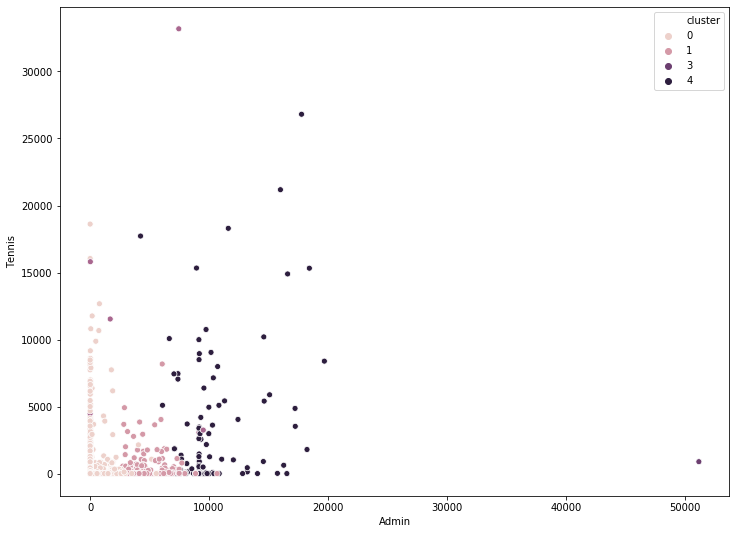

In [179]:
plt.figure(figsize=(12,9))
sns.scatterplot(x="Admin",y="Tennis",data=categorical, hue="cluster")

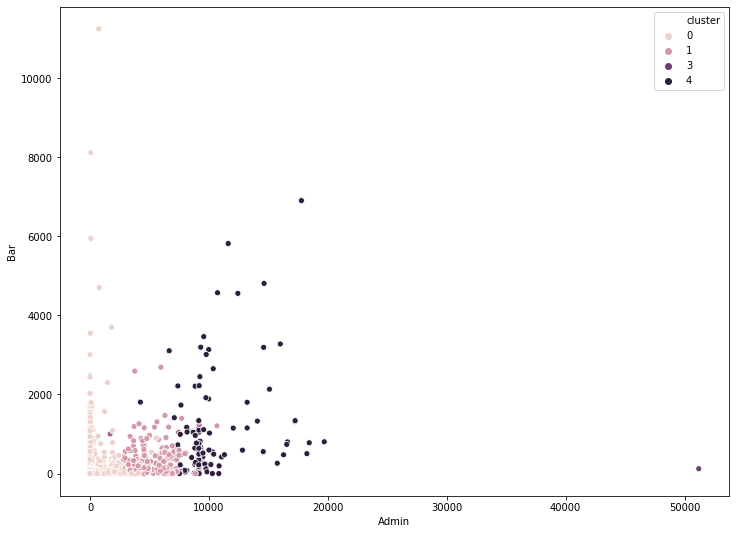

In [180]:
plt.figure(figsize=(12,9))
sns.scatterplot(x="Admin",y="Bar",data=categorical, hue="cluster")

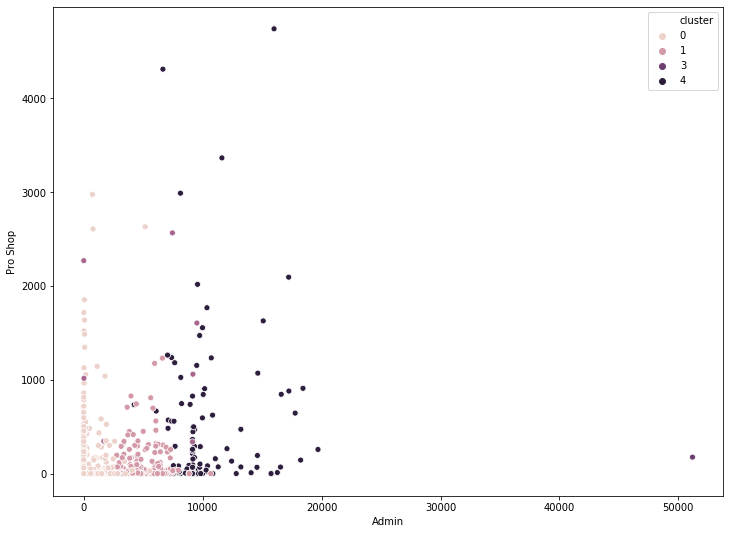

In [181]:
plt.figure(figsize=(12,9))
sns.scatterplot(x="Admin",y="Pro Shop",data=categorical, hue="cluster")

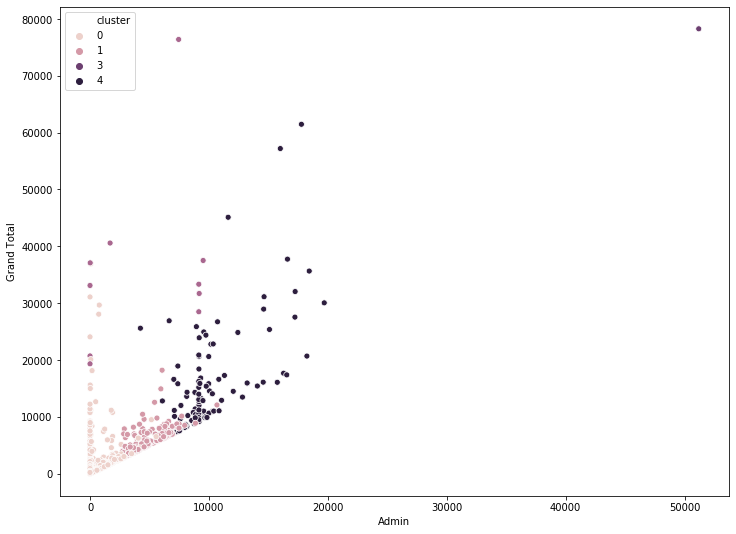

In [182]:
plt.figure(figsize=(12,9))
sns.scatterplot(x="Admin",y="Grand Total",data=categorical, hue="cluster")

Text(0.5, 0, 'Grand Total')

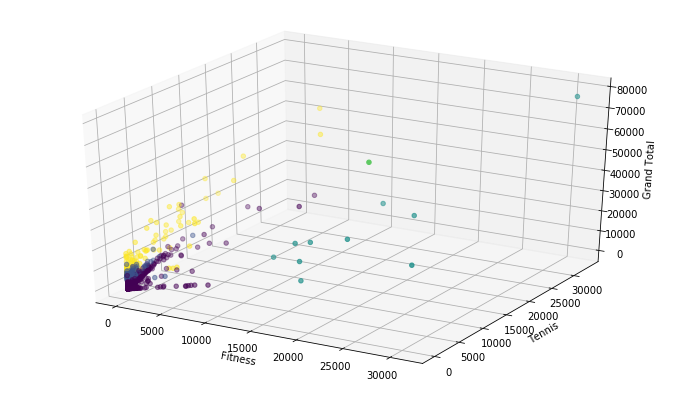

In [191]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, projection='3d')

# Plot models:

ax.scatter(categorical["Fitness"], categorical["Tennis"], categorical["Grand Total"],c=categorical.cluster.astype(np.float))

ax.set_xlabel('Fitness')
ax.set_ylabel('Tennis')
ax.set_zlabel('Grand Total')

### Clusters separated based on (1) Grand Total, (2) Atypically High Fitness and High Tennis

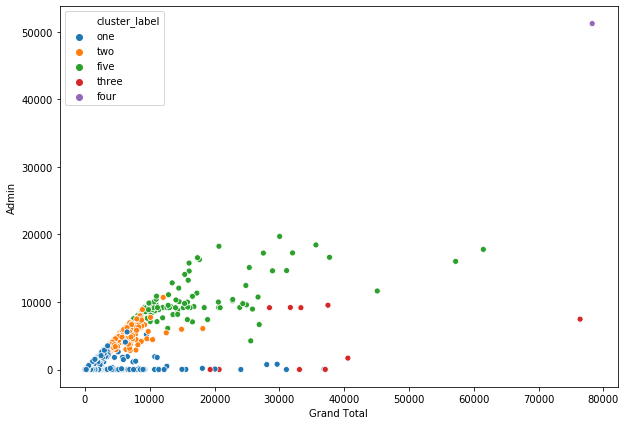

In [196]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="Grand Total",y="Admin", hue="cluster_label",data=categorical)

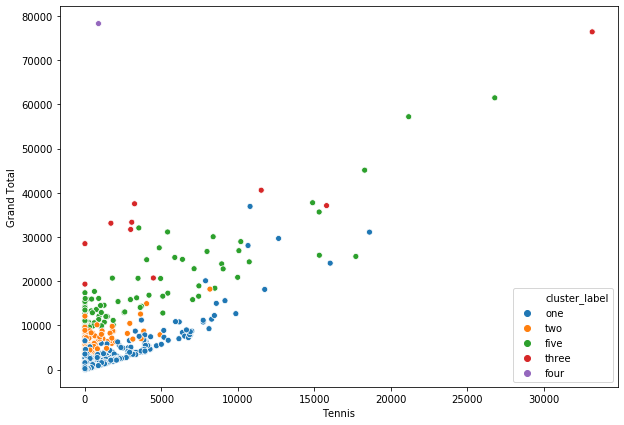

In [198]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="Tennis",y="Grand Total", hue="cluster_label",data=categorical)

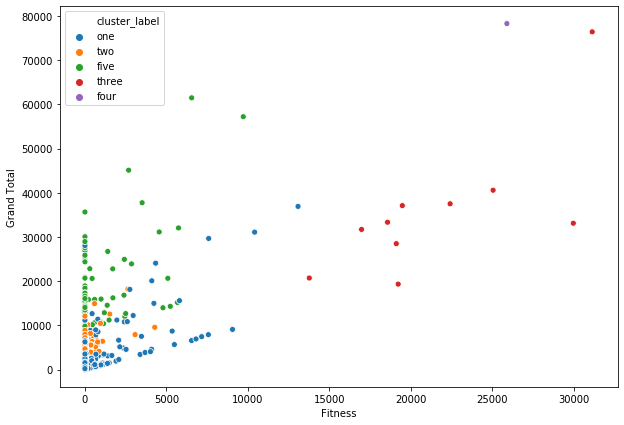

In [199]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="Fitness",y="Grand Total", hue="cluster_label",data=categorical)

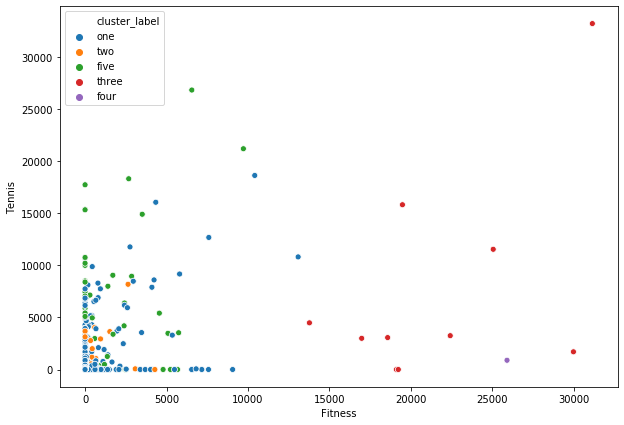

In [200]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="Fitness",y="Tennis", hue="cluster_label",data=categorical)

In [230]:
threes = list(categorical[categorical.cluster_label=="three"].index)

In [221]:
mem = pd.read_csv("cl_member.csv")

In [232]:
mem[mem.acn.isin(threes)]

,Unnamed: 0,trans_id,timestamp,name,item,item_group,status,quantity,subtotal,discount,tax,total,paid,refund,balance,acn,sys_id
55,55,37774,2015-08-12 15:52:00,Mike Shellman,Lessons with Joe Snailum (08/08/2015),Lessons,Paid,1.0,55.00,0.00,0.00,55.00,55.00,0.0,0.0,127,General Family Membership
115,115,38027,2015-08-18 08:30:00,Mike Shellman,Lessons with Joe Snailum (08/18/2015),Lessons,Paid,1.0,55.00,0.00,0.00,55.00,55.00,0.0,0.0,127,General Family Membership
172,172,37912,2015-08-15 09:43:00,Mark Kneuper,Group Event: Open Clinic (08/15/2015),Adult Clinics,Paid,1.0,25.00,0.00,0.00,25.00,25.00,0.0,0.0,227,General Property Owner
173,173,37912,2015-08-15 09:43:00,Mark Kneuper,Group Event: Open Clinic (08/15/2015),Adult Clinics,Paid,1.0,25.00,0.00,0.00,25.00,25.00,0.0,0.0,227,General Family Membership
174,174,37911,2015-08-15 09:42:00,Jean Kneuper,Group Event: Open Clinic (08/15/2015),Adult Clinics,Paid,1.0,25.00,0.00,0.00,25.00,25.00,0.0,0.0,940,General Property Owner
175,175,37911,2015-08-15 09:42:00,Jean Kneuper,Group Event: Open Clinic (08/15/2015),Adult Clinics,Paid,1.0,25.00,0.00,0.00,25.00,25.00,0.0,0.0,940,General Family Membership
186,186,37594,2015-08-10 08:17:00,Travis Wuest,Dasani Water bottle,Drinks,Paid,1.0,1.62,0.00,0.13,1.75,1.75,0.0,0.0,244,General Family Membership
187,187,37593,2015-08-10 08:17:00,Travis Wuest,Core Power,Drinks,Paid,1.0,3.46,0.00,0.29,3.75,3.75,0.0,0.0,244,General Family Membership
188,188,37592,2015-08-13 08:30:00,Mike Shellman,Lessons with Joe Snailum (08/13/2015),Lessons,Paid,1.0,55.00,0.00,0.00,55.00,55.00,0.0,0.0,127,General Family Membership
191,191,37578,2015-08-10 07:22:00,Travis Wuest,Group Event: Early Bird Drills (08/10/2015),Adult Clinics,Paid,1.0,15.00,0.00,0.00,15.00,15.00,0.0,0.0,244,General Family Membership


In [225]:
df[df.acn==343]

,acn,trans_id,timestamp,item,item_group,total,membership,group,city,state,zipcode,lat,long,category
44539,343,36620,2015-07-31 00:00:00,Membership for &quot;General Family Membership...,Membership Dues,422.18,General Single Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44540,343,36658,2015-07-31 00:00:00,Membership for &quot;Premier Family Membership...,Membership Dues,140.73,Premier Family Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44541,343,36658,2015-07-31 00:00:00,Membership for &quot;Premier Family Membership...,Membership Dues,140.73,General Family Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44542,343,36658,2015-07-31 00:00:00,Membership for &quot;Premier Family Membership...,Membership Dues,140.73,General Single Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44543,343,36620,2015-07-31 00:00:00,Membership for &quot;General Family Membership...,Membership Dues,422.18,General Family Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44544,343,36620,2015-07-31 00:00:00,Membership for &quot;General Family Membership...,Membership Dues,422.18,Premier Family Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44545,343,40626,2015-08-31 00:00:00,Membership for &quot;Premier Family Membership...,Membership Dues,140.73,Premier Family Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44546,343,40626,2015-08-31 00:00:00,Membership for &quot;Premier Family Membership...,Membership Dues,140.73,General Family Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44547,343,40626,2015-08-31 00:00:00,Membership for &quot;Premier Family Membership...,Membership Dues,140.73,General Single Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44548,343,40585,2015-08-31 00:00:00,Membership for &quot;General Family Membership...,Membership Dues,422.18,Premier Family Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin


### Clusters three and four are the high fitness clusters

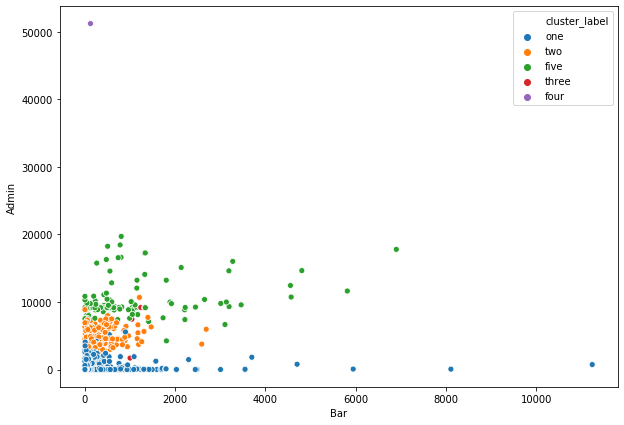

In [212]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="Bar",y="Admin", hue="cluster_label",data=categorical)

### Maybe? Clusters one, two, and five are just differences in Admin Total

<BarContainer object of 2725 artists>

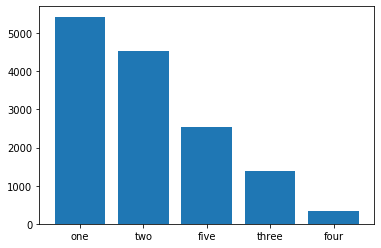

In [213]:
plt.bar(x="cluster_label",height=categorical.index,data=categorical)

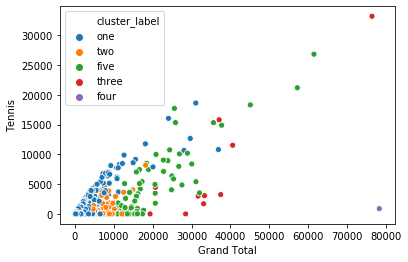

In [214]:
sns.scatterplot(x="Grand Total",y="Tennis",data=categorical,hue="cluster_label")

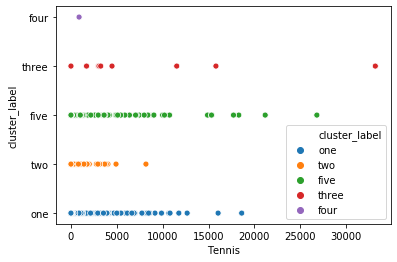

In [215]:
sns.scatterplot(x="Tennis",y="cluster_label",data=categorical,hue="cluster_label")

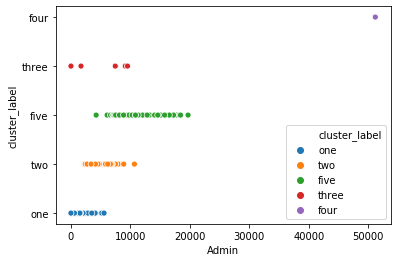

In [216]:
sns.scatterplot(x="Admin",y="cluster_label",data=categorical,hue="cluster_label")

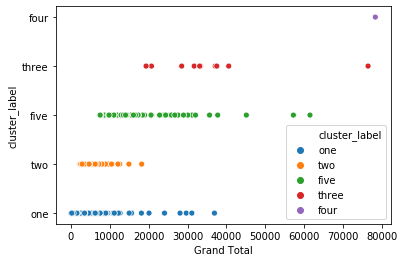

In [217]:
sns.scatterplot(x="Grand Total",y="cluster_label",data=categorical,hue="cluster_label")

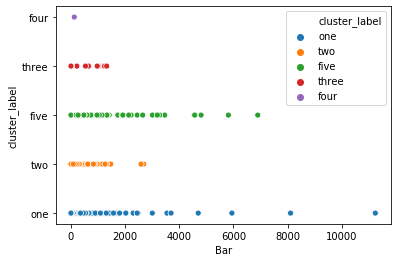

In [218]:
sns.scatterplot(x="Bar",y="cluster_label",data=categorical,hue="cluster_label")

### Cluster One - Low Admin, Mid Grand Total, High Bar
### Cluster Two - Mid Admin, Low Grand Total, Low Bar
### Cluster Five - High Admin, High Grand Total, Mid Bar

In [219]:
df.head()

,acn,trans_id,timestamp,item,item_group,total,membership,group,city,state,zipcode,lat,long,category
0,11,37777,2015-08-12 16:03:00,Core Power,Beverage,2.80,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
1,11,38361,2015-08-21 08:02:00,Berries Amore,Beverage,4.28,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
2,11,38360,2015-08-21 08:02:00,Smoothie Add-On,Beverage,0.67,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
3,11,35130,2015-07-24 11:53:00,$2.00 Ice Cream,Food & Consumables,2.00,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
4,11,35131,2015-07-24 11:53:00,$2.00 Ice Cream,Food & Consumables,2.00,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar


## Clustering Isolating Activities

In [362]:
act_only = df[df.category.isin(["Tennis","Program","Event","Fitness"])]

In [363]:
itemized_act = pd.pivot_table(act_only,values="total",index="acn",columns="item_group",fill_value=0,aggfunc=sum)

In [364]:
itemized_act["Grand Total"] = itemized_act.sum(axis=1)

In [365]:
kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(itemized_act)
clusters = pd.DataFrame(index=itemized_act.index, data=kmeans.labels_,columns=["cluster"])

In [366]:
act_cluster = itemized_act.join(clusters)

In [367]:
act_cluster.cluster.value_counts()

0    1780
5     111
4      36
2       9
1       9
3       1
Name: cluster, dtype: int64

In [370]:
act_only = act_only.set_index("acn")
act_only = act_only.pivot_table(values="total",index=act_only.index,columns="category",aggfunc=sum,fill_value=0)
activity = act_only.join(act_cluster)

In [371]:
activity.head()

,Event,Fitness,Program,Tennis,24 Hour of Tennis,Adult Clinics,Camp,Court Time,Date Night,Dinners,...,Leagues,Personal Training,Social Event,Special Event,Swim Camp,Swim Lessons,Teen Performance Camp,Tennis Lessons,Grand Total,cluster
acn,,,,,,,,,,,,,,,,,,,,,
11,80.00,0.0,90.0,208.30,0.0,24.30,0.0,0.0,35.0,0.00,...,0.0,0.0,0.0,45.00,0,90,0.0,184.00,378.30,0
17,0.00,0.0,0.0,30.00,0.0,30.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0,0,0.0,0.00,30.00,0
23,0.00,0.0,0.0,1614.26,0.0,0.01,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0,0,0.0,1614.25,1614.26,0
33,105.12,0.0,0.0,36.00,0.0,36.00,0.0,0.0,0.0,12.99,...,0.0,0.0,0.0,92.13,0,0,0.0,0.00,141.12,0
34,2552.20,0.0,0.0,0.00,0.0,0.00,0.0,0.0,52.2,0.00,...,0.0,0.0,0.0,0.00,0,0,0.0,0.00,2552.20,0


In [372]:
condition = [activity.cluster == 0, activity.cluster == 1, activity.cluster == 2, activity.cluster == 3, activity.cluster == 4, activity.cluster == 5]
choice = ["one","two","three","four","five","six"]
activity["cluster_label"] = np.select(condition,choice,0)

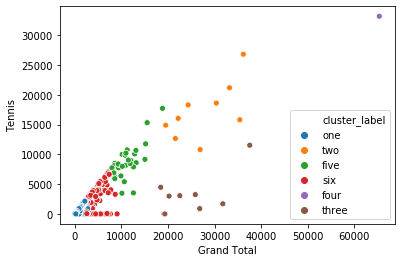

In [373]:
sns.scatterplot(data=activity,x="Grand Total",y="Tennis",hue="cluster_label")

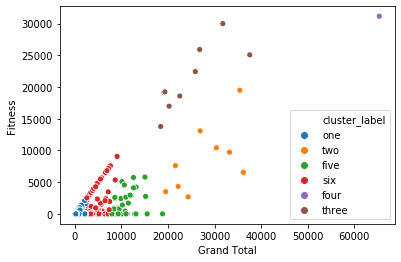

In [374]:
sns.scatterplot(data=activity,x="Grand Total",y="Fitness",hue="cluster_label")

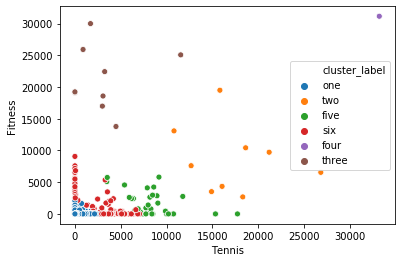

In [375]:
sns.scatterplot(data=activity,x="Tennis",y="Fitness",hue="cluster_label")

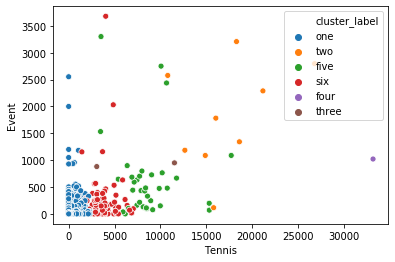

In [376]:
sns.scatterplot(data=activity,x="Tennis",y="Event",hue="cluster_label")

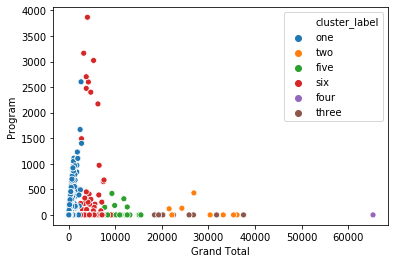

In [378]:
sns.scatterplot(data=activity,x="Grand Total",y="Program",hue="cluster_label")

## Cluster Two - High Tennis and/or Event
## Cluster Four - High Fitness

In [379]:
ot = activity[activity.cluster_label.isin(["one","three"])]

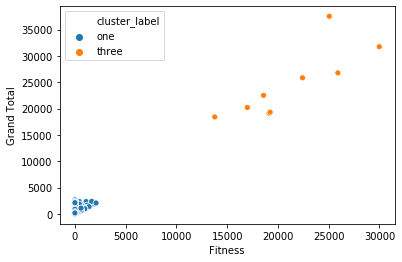

In [380]:
sns.scatterplot(data=ot,x="Fitness",y="Grand Total",hue="cluster_label")

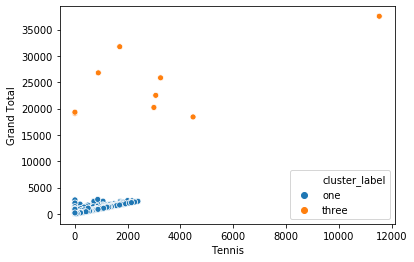

In [381]:
sns.scatterplot(data=ot,x="Tennis",y="Grand Total",hue="cluster_label")

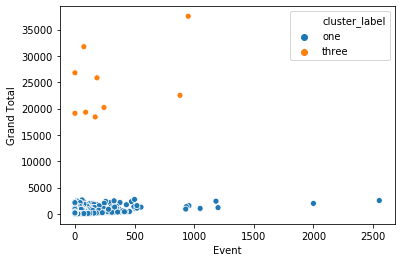

In [382]:
sns.scatterplot(data=ot,x="Event",y="Grand Total",hue="cluster_label")

In [383]:
ot.head()

,Event,Fitness,Program,Tennis,24 Hour of Tennis,Adult Clinics,Camp,Court Time,Date Night,Dinners,...,Personal Training,Social Event,Special Event,Swim Camp,Swim Lessons,Teen Performance Camp,Tennis Lessons,Grand Total,cluster,cluster_label
acn,,,,,,,,,,,,,,,,,,,,,
11,80.00,0.0,90.0,208.30,0.0,24.30,0.0,0.0,35.0,0.00,...,0.0,0.0,45.00,0,90,0.0,184.00,378.30,0,one
17,0.00,0.0,0.0,30.00,0.0,30.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0,0,0.0,0.00,30.00,0,one
23,0.00,0.0,0.0,1614.26,0.0,0.01,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0,0,0.0,1614.25,1614.26,0,one
33,105.12,0.0,0.0,36.00,0.0,36.00,0.0,0.0,0.0,12.99,...,0.0,0.0,92.13,0,0,0.0,0.00,141.12,0,one
34,2552.20,0.0,0.0,0.00,0.0,0.00,0.0,0.0,52.2,0.00,...,0.0,0.0,0.00,0,0,0.0,0.00,2552.20,0,one


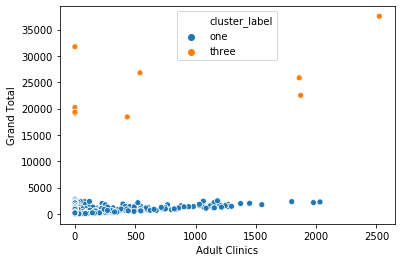

In [384]:
sns.scatterplot(data=ot,x="Adult Clinics",y="Grand Total",hue="cluster_label")

---

In [550]:
norm = df[df.category!="Admin"]

# Time Series

In [551]:
norm.timestamp = pd.to_datetime(norm.timestamp)

In [552]:
dt = norm.set_index("timestamp")

## Monthly Average per user

In [553]:
monthly = dt.groupby("acn").resample("M")[["total"]].median().reset_index()
monthly.fillna(0,inplace=True)

In [554]:
monthly["month"] = monthly.timestamp.dt.strftime("%m")

In [555]:
monthly_average = monthly.groupby(["acn","month"])[["total"]].median()

In [556]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(monthly_average)
clusters = pd.DataFrame(index=monthly_average.index, data=kmeans.labels_,columns=["cluster"])

In [557]:
monthly_average = monthly_average.copy().join(clusters)

In [558]:
monthly_average.reset_index(inplace=True)

In [559]:
monthly_average.cluster.value_counts()

1    15284
0     2159
4      746
2      232
3        1
Name: cluster, dtype: int64

In [560]:
condition = [monthly_average.cluster == 0, monthly_average.cluster == 1, monthly_average.cluster == 2, monthly_average.cluster == 3, monthly_average.cluster == 4]
choice = ["one","two","three","four","five"]
monthly_average["cluster_label"] = np.select(condition,choice,0)

In [561]:
# condition = [monthly_average.cluster == 0, monthly_average.cluster == 1, monthly_average.cluster == 2, monthly_average.cluster == 3, monthly_average.cluster == 4, monthly_average.cluster == 5,monthly_average.cluster == 6,monthly_average.cluster == 7]
# choice = ["one","two","three","four","five","six","seven","eight"]
# monthly_average["cluster_label"] = np.select(condition,choice,0)

In [562]:
# pd.pivot_table(data=monthly_average,index="acn",values="total",columns="cluster",aggfunc=np.median)

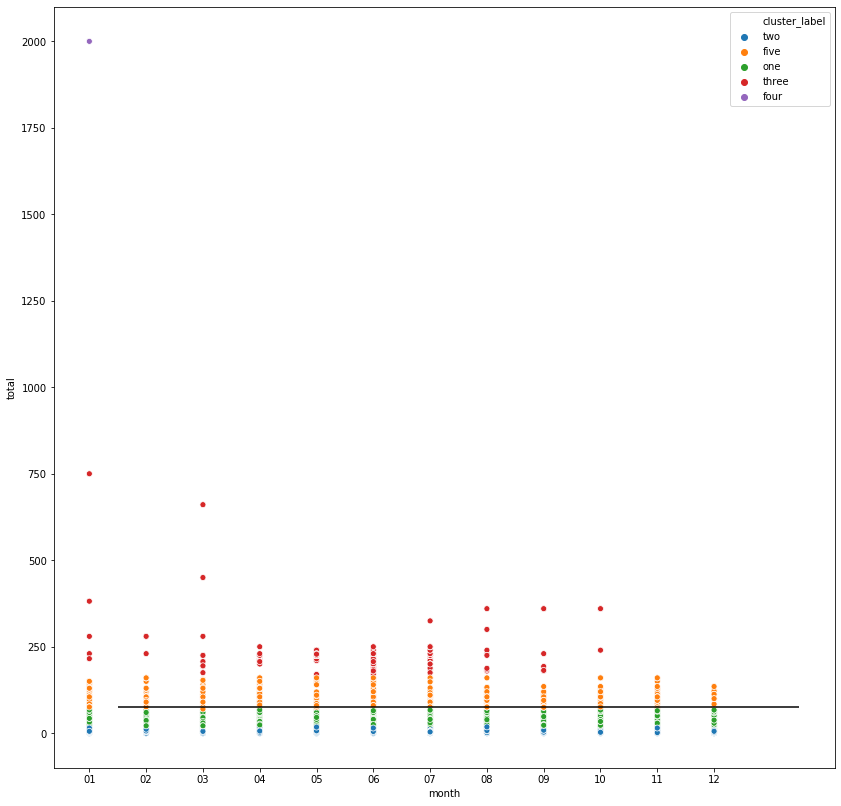

In [563]:
plt.figure(figsize=(14,14))
sns.scatterplot(data=monthly_average,x="month",y="total",hue="cluster_label")

plt.hlines(y=monthly_average.total.quantile(.95),xmin=0.5,xmax=12.5)

In [564]:
monthly_average.total.quantile(.75)

8.66

In [581]:
monthly_average

acn                11
month              12
total            3.56
cluster             1
cluster_label     two
Name: 11, dtype: object

In [601]:
monthly_cluster = monthly_average.groupby(["acn","cluster_label"])[["cluster_label"]].count().rename(columns={"cluster_label":"count"}).sort_values(by=["acn","count"],ascending=False).reset_index()

In [609]:
monthly_cluster = monthly_cluster.drop_duplicates(subset="acn",keep="first").drop(columns="count")
monthly_cluster.set_index("acn",inplace=True)

In [628]:
monthly_cluster.shape

(2567, 1)

In [618]:
norm.set_index("acn",inplace=True)

In [620]:
norm = norm.join(monthly_cluster)

In [637]:
by_cat = category.copy()
by_cat["Grand Total"] = by_cat.sum(axis=1)

In [638]:
by_cat = by_cat.join(monthly_cluster).fillna({"cluster_label":"admin_only"})

In [641]:
by_cat[by_cat.cluster_label=="admin_only"]

,Admin,Bar,Event,Fitness,Pro Shop,Program,Tennis,Grand Total,cluster_label
acn,,,,,,,,,
64,2673.87,0.0,0.0,0.0,0.0,0.0,0.0,2673.87,admin_only
68,1548.03,0.0,0.0,0.0,0.0,0.0,0.0,1548.03,admin_only
70,562.92,0.0,0.0,0.0,0.0,0.0,0.0,562.92,admin_only
72,2955.33,0.0,0.0,0.0,0.0,0.0,0.0,2955.33,admin_only
85,281.46,0.0,0.0,0.0,0.0,0.0,0.0,281.46,admin_only
86,985.11,0.0,0.0,0.0,0.0,0.0,0.0,985.11,admin_only
90,985.11,0.0,0.0,0.0,0.0,0.0,0.0,985.11,admin_only
94,281.46,0.0,0.0,0.0,0.0,0.0,0.0,281.46,admin_only
96,1829.49,0.0,0.0,0.0,0.0,0.0,0.0,1829.49,admin_only


---

# Feb 4 - Customer Lifetime Value

In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("main_df.csv", low_memory=False)

In [5]:
df.head()

,acn,trans_id,timestamp,item,item_group,total,membership,group,city,state,zipcode,lat,long,category
0,11,37777,2015-08-12 16:03:00,Core Power,Beverage,2.80,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
1,11,38361,2015-08-21 08:02:00,Berries Amore,Beverage,4.28,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
2,11,38360,2015-08-21 08:02:00,Smoothie Add-On,Beverage,0.67,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
3,11,35130,2015-07-24 11:53:00,$2.00 Ice Cream,Food & Consumables,2.00,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
4,11,35131,2015-07-24 11:53:00,$2.00 Ice Cream,Food & Consumables,2.00,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar


In [16]:
df.shape

(141967, 14)

In [22]:
df.total.describe()
#max is ~3500k

count    141967.000000
mean         38.659745
std          71.270538
min           0.010000
25%           3.750000
50%          10.830000
75%          48.710000
max        3464.000000
Name: total, dtype: float64

There are entries > $2000 and are typically entered as a membership initiation. This is OK because when looking at RFM, frequency will gather less weight if the high-value spend is a one-time thing. 

In [24]:
df.timestamp = pd.to_datetime(df.timestamp)

## Recency

1. Group by acn and get max transaction date (most recent)
2. Calculate recency by subtracting the df's most recent transaction - acn's max purchase date in days

In [220]:
customer = df.groupby('acn')[["timestamp"]].max()

In [221]:
#latest POS purchase
customer.timestamp.max()

Timestamp('2019-12-31 18:23:00')

In [222]:
customer["recency"] = (customer.timestamp.max() - customer.timestamp).dt.days

`recency` of 0 is very recent

Now, let's see the most optimal clusters using elbow method.

In [264]:
customer.head()

,timestamp,recency,recency_cluster,frequency,frequency_cluster,total,monetary_cluster,rfm_score
acn,,,,,,,,
11,2019-12-31 14:01:00,0,1,169,3,1275.00,6,10
17,2015-04-04 11:32:00,1732,4,2,0,49.50,6,10
23,2019-12-20 12:10:00,11,1,148,3,2640.54,5,9
33,2019-12-31 00:00:00,0,1,56,2,3782.62,5,8
34,2018-09-30 00:00:00,457,2,34,0,7798.28,4,6


   k           sse
0  1  8.621151e+08
1  2  1.822063e+08
2  3  6.745167e+07
3  4  3.727469e+07
4  5  2.341644e+07
5  6  1.410832e+07
6  7  1.095286e+07
7  8  8.476024e+06
8  9  6.640931e+06


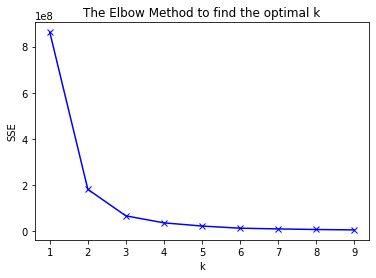

In [223]:
sse = []
ks = range(1,10)

for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(customer[["recency"]])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

Seems like 4 is a good number for most optimal cluster.  
Let's label each `acn` with a recency cluster.

In [224]:
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(customer[["recency"]])
customer["recency_cluster"] = kmeans.predict(customer[["recency"]])

In [225]:
customer.recency_cluster.value_counts()

2    1257
0     604
1     484
3     380
Name: recency_cluster, dtype: int64

In [226]:
customer.groupby("recency_cluster").recency.describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,604.0,515.201987,112.551056,299.0,432.00,522.0,594.0,743.0
1,484.0,1544.572314,157.346083,1263.0,1403.25,1613.0,1664.5,1824.0
2,1257.0,81.385839,87.493921,0.0,0.00,54.0,144.0,295.0
3,380.0,978.397368,145.858581,747.0,865.75,946.0,1085.0,1259.0


In [227]:
condition = [customer.recency_cluster ==0,customer.recency_cluster ==1,customer.recency_cluster ==2,customer.recency_cluster ==3]
choice = [2,4,1,3]
customer["recency_cluster_sorted"] = np.select(condition,choice,"nan")
customer.drop(columns="recency_cluster",inplace=True)

In [228]:
customer.rename(columns={"recency_cluster_sorted":"recency_cluster"},inplace=True)

### Recency Clusters
- 1: Recent
- 2: Fairly recent
- 3: Passive
- 4: Inactive

## Frequency

In [136]:
freq = df.copy()

In [138]:
freq["day"] = (freq.timestamp.max() - freq.timestamp).dt.days

In [147]:
frequency = freq.groupby(["acn","day"])[["day"]].count().rename(columns={"day":"times_in_day"}).reset_index().groupby("acn")[["day"]].count().rename(columns={"day":"frequency"})

In [149]:
frequency.head()

,frequency
acn,
11,169
17,2
23,148
33,56
34,34


`frequency` of 1 is just one POS entry.

In [170]:
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(frequency[["frequency"]])
frequency["frequency_cluster"] = kmeans.predict(frequency[["frequency"]])

In [171]:
frequency.groupby("frequency_cluster").frequency.describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,2235.0,7.015660,8.326551,1.0,1.00,3.0,10.00,39.0
1,32.0,419.000000,86.562303,314.0,353.25,411.0,463.25,634.0
2,361.0,72.761773,23.878367,40.0,51.00,70.0,90.00,132.0
3,97.0,195.814433,45.950002,136.0,157.00,192.0,219.00,305.0


In [266]:
condition = [frequency.frequency_cluster==0,frequency.frequency_cluster==1,frequency.frequency_cluster==2,frequency.frequency_cluster==3]
choice = [4,1,3,2]
frequency["freq_sorted"] = np.select(condition,choice,"nan")

In [267]:
frequency = frequency.drop(columns="frequency_cluster")
frequency.rename(columns={"freq_sorted":"frequency_cluster"},inplace=True)

### Frequency Clusters
- 1: Frequent
- 2: Fairly frequent
- 3: Passive
- 4: Inactive

In [268]:
frequency.frequency_cluster.value_counts()

4    2235
3     361
2      97
1      32
Name: frequency_cluster, dtype: int64

## Monetary

In [210]:
monetary = df.copy().groupby("acn")[["total"]].sum()

In [211]:
monetary.head()

,total
acn,
11,1275.00
17,49.50
23,2640.54
33,3782.62
34,7798.28


   k           sse
0  1  6.928952e+10
1  2  2.872867e+10
2  3  1.285348e+10
3  4  7.199233e+09
4  5  4.415108e+09
5  6  2.923038e+09
6  7  2.239695e+09
7  8  1.659436e+09
8  9  1.340696e+09


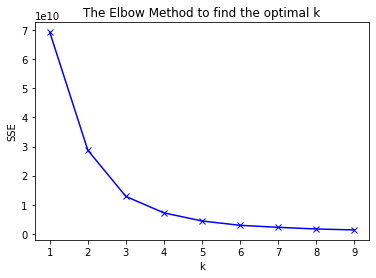

In [212]:
sse = []
ks = range(1,10)

for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(monetary[["total"]])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [213]:
kmeans = KMeans(n_clusters=6, random_state=123)
kmeans.fit(monetary[["total"]])
monetary["mc"] = kmeans.predict(monetary[["total"]])

In [214]:
monetary.head()

,total,mc
acn,,
11,1275.00,0
17,49.50,0
23,2640.54,4
33,3782.62,4
34,7798.28,2


In [215]:
monetary.groupby("mc").total.describe()

,count,mean,std,min,25%,50%,75%,max
mc,,,,,,,,
0,2143.0,344.927699,451.288007,1.00,42.1000,161.750,434.2000,2010.31
1,50.0,16235.872000,2797.037181,12550.00,14104.4700,15838.690,18008.3500,22810.09
2,199.0,8396.929849,1606.548682,6117.39,7030.3200,8052.730,9602.5900,12218.55
3,4.0,68343.170000,10567.694244,57203.88,60409.8375,68944.195,76877.5275,78280.41
4,300.0,3682.994600,1162.031397,2027.82,2660.5550,3507.300,4653.9675,5980.31
5,29.0,30626.700690,5521.511293,23901.59,25857.2800,29658.430,33328.1400,45110.68


In [216]:
condition = [monetary.mc == 0,monetary.mc == 1,monetary.mc == 2,monetary.mc == 3,monetary.mc == 4,monetary.mc == 5]
choice = [6,3,4,1,5,2]
monetary["mon_srtd"] = np.select(condition,choice,"nan")

In [217]:
monetary = monetary.drop(columns="mc")
monetary.rename(columns={"mon_srtd":"monetary_cluster"},inplace=True)

monetary.head()

,total,monetary_cluster
acn,,
11,1275.00,6
17,49.50,6
23,2640.54,5
33,3782.62,5
34,7798.28,4


### Monetary Clusters
- 1: Very High Spender
- 2: High Spender
- 3: Fairly High Spender
- 4: Average Spender
- 5: Low Spender
- 6: Minimum Spender

In [235]:
monetary.monetary_cluster.value_counts()

6    2143
5     300
4     199
3      50
2      29
1       4
Name: monetary_cluster, dtype: int64

## Combining RFM

In [229]:
customer = customer.join([frequency,monetary])

In [230]:
customer.head()

,timestamp,recency,recency_cluster,frequency,frequency_cluster,total,monetary_cluster
acn,,,,,,,
11,2019-12-31 14:01:00,0,1,169,3,1275.00,6
17,2015-04-04 11:32:00,1732,4,2,0,49.50,6
23,2019-12-20 12:10:00,11,1,148,3,2640.54,5
33,2019-12-31 00:00:00,0,1,56,2,3782.62,5
34,2018-09-30 00:00:00,457,2,34,0,7798.28,4


In [233]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2725 entries, 11 to 5434
Data columns (total 7 columns):
timestamp            2725 non-null datetime64[ns]
recency              2725 non-null int64
recency_cluster      2725 non-null object
frequency            2725 non-null int64
frequency_cluster    2725 non-null int32
total                2725 non-null float64
monetary_cluster     2725 non-null object
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(2)
memory usage: 239.7+ KB


In [239]:
customer.recency_cluster = customer.recency_cluster.astype("int")
customer.monetary_cluster = customer.monetary_cluster.astype("int")

In [240]:
customer["rfm_score"] = customer.recency_cluster + customer.frequency_cluster + customer.monetary_cluster

In [257]:
customer.rfm_score.value_counts().sort_values()

12      1
11      2
3       2
4      14
5      17
6     110
9     420
10    499
8     721
7     939
Name: rfm_score, dtype: int64

(array([  2.,  14.,  17., 110., 939., 721., 420., 499.,   2.,   1.]),
 array([ 3. ,  3.9,  4.8,  5.7,  6.6,  7.5,  8.4,  9.3, 10.2, 11.1, 12. ]),
 <a list of 10 Patch objects>)

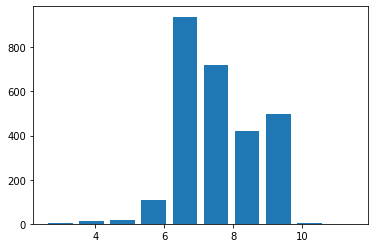

In [263]:
plt.hist(customer.rfm_score,rwidth=0.8,align="left")

### RFM Score Range:
- 3-7 = High Value
- 8-9 = Mid Value
- 10-12 = Low Value